In [ ]:
!pip uninstall -y keras-nlp keras-hub
!pip install -U keras-hub keras-tuner --quiet

In [2]:
#import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_hub
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
import keras_cv
import keras_tuner as kt

In [3]:
#config
BASE_PATH = "/kaggle/input/acne-grading-classificationdataset/Created Dataset"
CLASSES = ["Level_0", "Level_1", "Level_2"]
IMG_SIZE = 224
BATCH_SIZE = 16 
EPOCHS = 100
INITIAL_LR = 1e-5 

In [4]:
#data prep
filepaths, labels = [], []
for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                filepaths.append(os.path.join(folder, f))
                labels.append(cls)

df = pd.DataFrame({"filename": filepaths, "class": labels})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)

In [5]:
#focal loss/mix up
def balanced_focal_loss(gamma=2.5):
    alpha_weights = tf.constant([0.86, 0.70, 3.60], dtype=tf.float32) 
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_term = tf.math.pow(1.0 - y_pred, gamma)
        weighted_loss = alpha_weights * focal_term * cross_entropy
        return tf.math.reduce_sum(weighted_loss, axis=1)
    return loss_fn

def mixup_data_gen(generator, alpha=0.2):
    while True:
        batch = next(generator)
        X1, y1 = batch[0], batch[1]
        X2, y2 = next(generator)
        batch_size = min(X1.shape[0], X2.shape[0])
        l = np.random.beta(alpha, alpha, batch_size)
        X_l = l.reshape(batch_size, 1, 1, 1).astype('float32')
        y_l = l.reshape(batch_size, 1).astype('float32')
        X_mix = X1[:batch_size] * X_l + X2[:batch_size] * (1.0 - X_l)
        y_mix = y1[:batch_size] * y_l + y2[:batch_size] * (1.0 - y_l)
        yield (X_mix, y_mix)

In [6]:
#datagens
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True
)
val_loader = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)
train_loader_mixup = mixup_data_gen(train_loader)

Found 799 validated image filenames belonging to 3 classes.
Found 200 validated image filenames belonging to 3 classes.


In [10]:
import keras_hub
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

def build_tunable_model(hp):
    model = keras_hub.models.ImageClassifier.from_preset(
        "vit_base_patch16_224_imagenet21k",
        num_classes=len(CLASSES),
        load_weights=True
    )
    
    model.backbone.trainable = True
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = model.backbone(inputs)
    
    if len(x.shape) == 3:
        x = layers.Lambda(lambda t: t[:, 0, :])(x)
    
    x = layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    )(x)
    
    x = layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='gelu'
    )(x)
    
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    new_model = Model(inputs, outputs)
    
    lr = hp.Float('learning_rate', min_value=1e-6, max_value=1e-4, sampling='log')
    
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=balanced_focal_loss(), 
        metrics=['accuracy']
    )
    return new_model

#bayesian opt.
tuner = kt.BayesianOptimization(
    build_tunable_model,
    objective="val_accuracy",
    max_trials=10,
    directory="tuning_results",
    project_name="acne_vit_tuning",
    overwrite=True
)

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_loader_mixup,
    epochs=5, 
    validation_data=val_loader,
    callbacks=[stop_early],
    steps_per_epoch=len(train_df) // BATCH_SIZE 
)

Trial 10 Complete [00h 04m 23s]
val_accuracy: 0.7099999785423279

Best val_accuracy So Far: 0.7699999809265137
Total elapsed time: 00h 45m 42s


In [17]:
# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
En iyi değerler:
- Dense Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


En iyi değerler:
- Dense Units: 384
- Dropout Rate: 0.5
- Learning Rate: 2.1976602707665945e-05



In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_vit_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8, verbose=1)
]

In [20]:
#training
model = tuner.hypermodel.build(best_hps)

# Final eğitimi (Senin callbacklerinle)
history = model.fit(
    train_loader_mixup,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks 
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.4116 - loss: 0.4252
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to best_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4120 - loss: 0.4245 - val_accuracy: 0.5600 - val_loss: 0.2599 - learning_rate: 2.1977e-05
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.5755 - loss: 0.3084
Epoch 2: val_accuracy improved from 0.56000 to 0.68000, saving model to best_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 851ms/step - accuracy: 0.5752 - loss: 0.3083 - val_accuracy: 0.6800 - val_loss: 0.1935 - learning_rate: 2.1977e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.5777 - loss: 0.2753
Epoch 3: val_accuracy improved from 0.68000 to 0.70500, saving model to best_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - accuracy: 0.5781 - loss: 0.2750 - val_accuracy: 0.7050 - val_loss: 0.1906 - learning_rate: 2.1977e-05
Epoch 4/100
49/49 ━━━━━━━━━

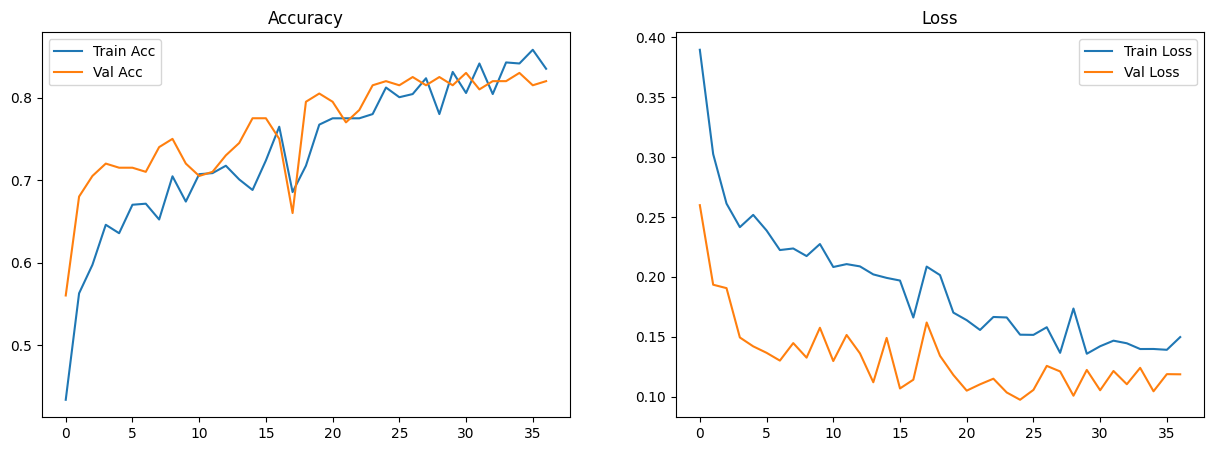

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step


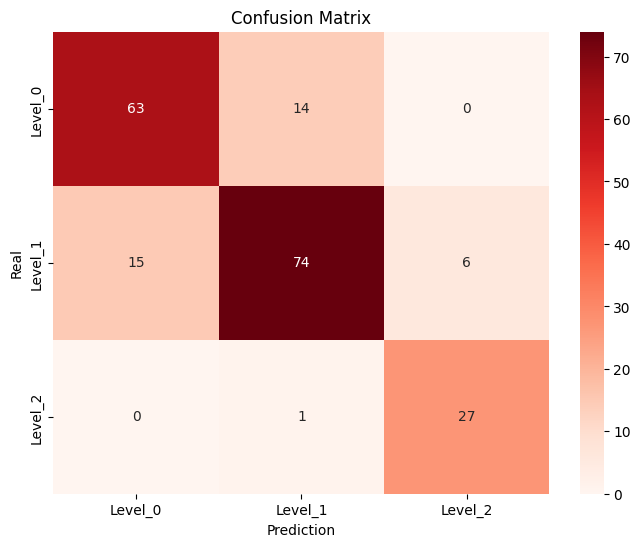

              precision    recall  f1-score   support

     Level_0       0.81      0.82      0.81        77
     Level_1       0.83      0.78      0.80        95
     Level_2       0.82      0.96      0.89        28

    accuracy                           0.82       200
   macro avg       0.82      0.85      0.83       200
weighted avg       0.82      0.82      0.82       200



In [21]:
#results
def plot_results(history, model, loader, classes):
    # Accuracy loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    #conf matrix
    loader.reset()
    y_true = loader.classes
    preds = model.predict(loader)
    y_pred = np.argmax(preds, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=classes))

plot_results(history, model, val_loader, CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


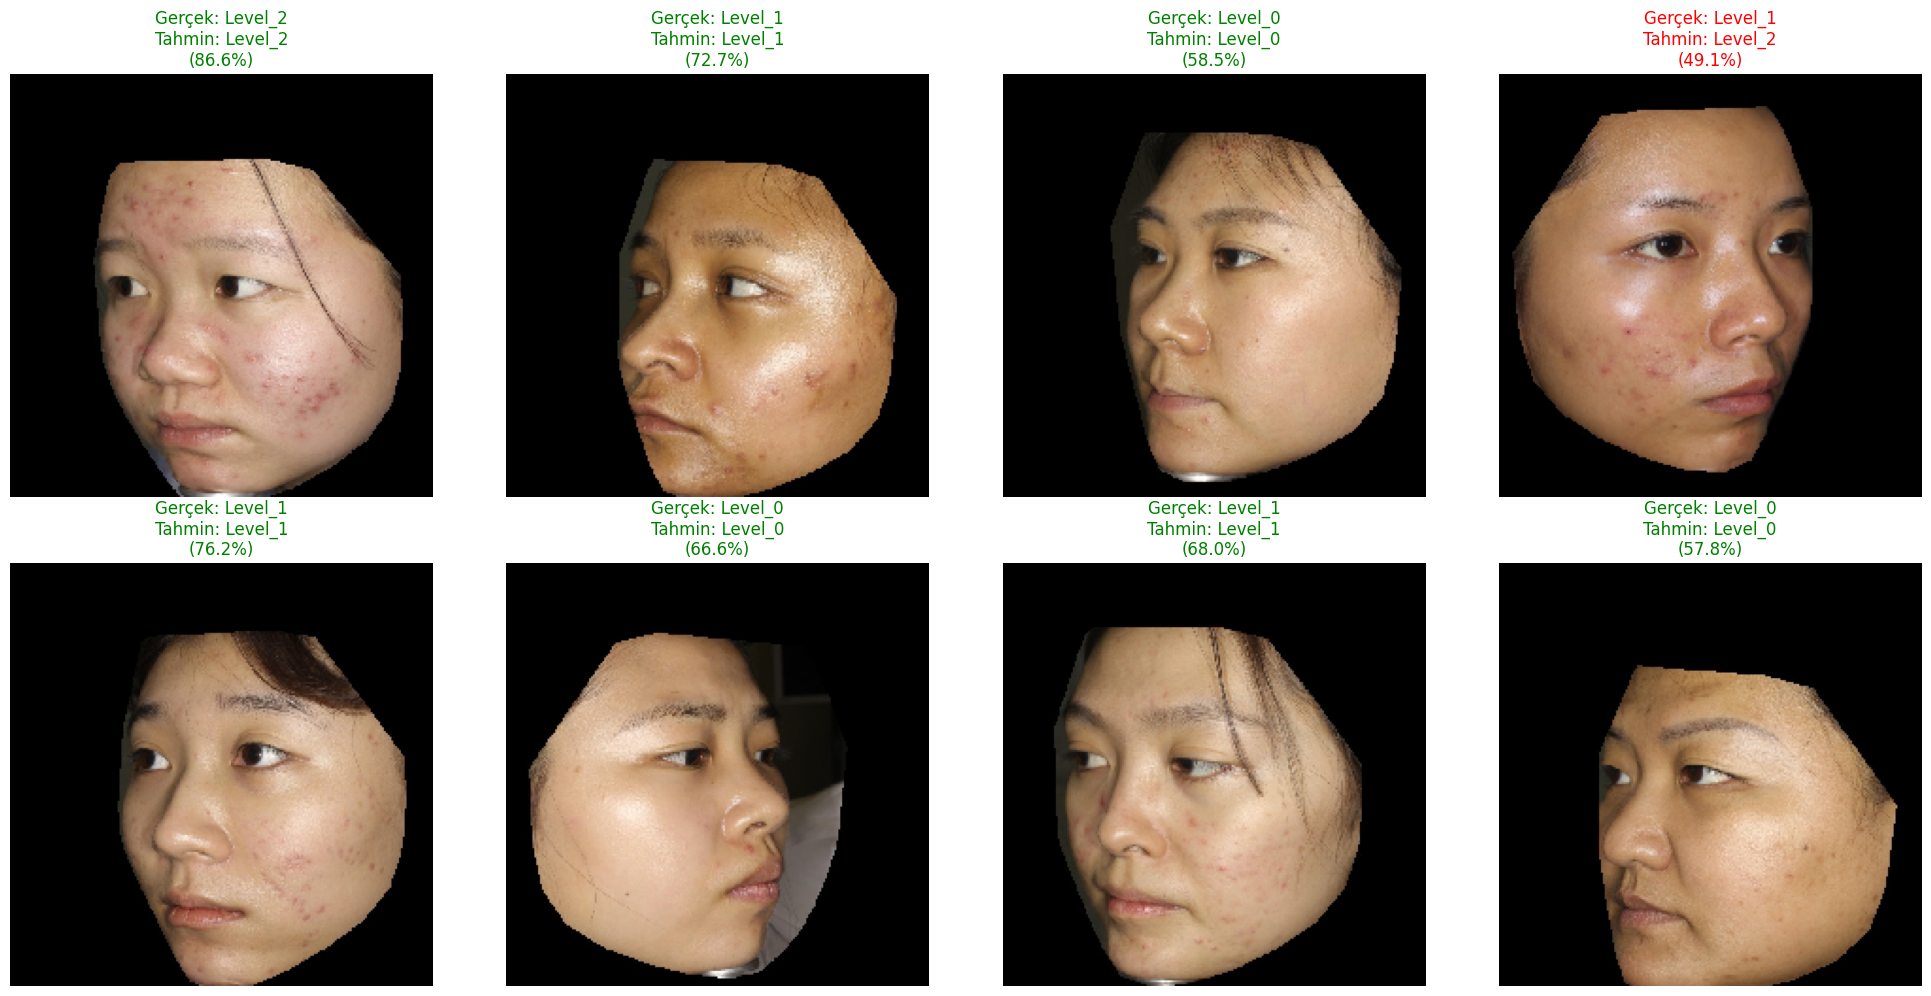

In [22]:
#predicts
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, classes, num_images=8):
    images, labels = next(loader)
    
    preds = model.predict(images)
    
    plt.figure(figsize=(20, 10))
    
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        
        plt.imshow(images[i])
        
        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(preds[i])
        confidence = preds[i][pred_idx] * 100
        
        color = 'green' if true_idx == pred_idx else 'red'
        
        plt.title(f"Gerçek: {classes[true_idx]}\nTahmin: {classes[pred_idx]}\n({confidence:.1f}%)", 
                  color=color, fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, CLASSES)